In [1]:
from utils import calculate_two_peaks_probability, sig, sigfit

## Experimental Data

In [2]:
import pandas as pd

# Load data
df = pd.read_csv("DFI_SPQ_Data.csv")
data = pd.melt(df, value_name="Flashes", var_name="Delay", id_vars=["ID", "Group"])
data["Flashes"] = (data["Flashes"] / 10) * 100

# Average data by group
avg_data = data.groupby(["Group", "Delay"])["Flashes"].aggregate(["mean"])
avg_data.reset_index(inplace=True)
avg_data.rename(columns={"mean": "Flashes (%)"}, inplace=True)
avg_data["Delay"] = avg_data.Delay.astype(float)

# Fit group data to sigmoid
for group in avg_data.groupby("Group"):
    if group[0] == "H-SPQ":
        group[1]["Fit"] = sig(
            x=group[1]["Delay"], a=14.6033, b=61.7941, c=86.2012, d=-27.569
        )
        df_hspq = group[1]
    elif group[0] == "L-SPQ":
        group[1]["Fit"] = sig(
            x=group[1]["Delay"], a=15.045, b=66.7106, c=59.806, d=-26.553
        )
        df_lspq = group[1]

dataset = pd.concat([df_hspq, df_lspq])
dataset.head()

## TODO double check fit values

,Group,Delay,Flashes (%),Fit
0,H-SPQ,108.0,35.357143,33.884199
1,H-SPQ,120.0,30.357143,28.623599
2,H-SPQ,132.0,27.142857,24.465345
3,H-SPQ,144.0,18.928571,21.365804
4,H-SPQ,156.0,18.214286,19.155035


<Axes: xlabel='Delay', ylabel='Flashes (%)'>

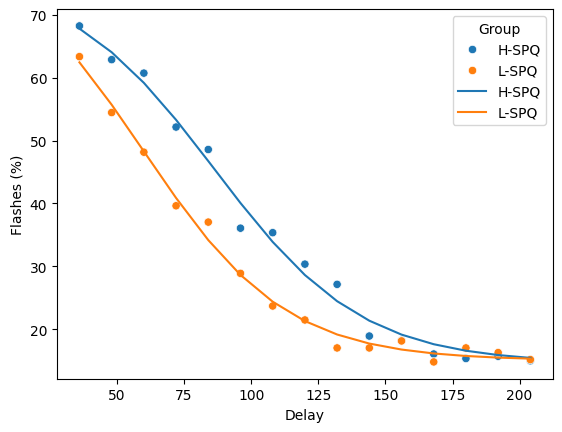

In [3]:
import seaborn as sns

sns.scatterplot(data=dataset, x="Delay", y="Flashes (%)", hue="Group")
sns.lineplot(data=dataset, x="Delay", y="Fit", hue="Group")

<Axes: xlabel='Delay', ylabel='Fit'>

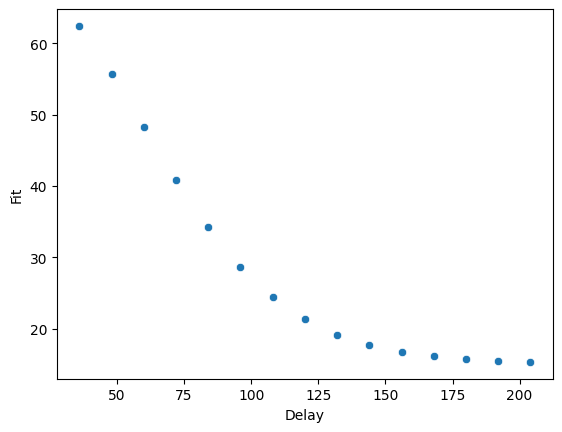

In [4]:
# Data to fit
lspq_data = dataset.query("Group == 'L-SPQ'").sort_values(by=["Delay"])["Fit"].values
soas = dataset.query("Group == 'L-SPQ'").sort_values(by=["Delay"])["Delay"].values
sns.scatterplot(data=dataset.query("Group == 'L-SPQ'"), y="Fit", x="Delay")

## Fitting

In [ ]:
from skneuromsi.neural import Paredes2022
from joblib import Parallel, delayed
import numpy as np
from scipy.optimize import differential_evolution
from findpeaks import findpeaks


def myjob(soa, cm_weight, fb_weight, ff_weight, a_tau, v_tau, m_tau):
    model = Paredes2022(
        time_range=(0, 500),
        neurons=30,
        position_range=(0, 30),
        tau=(a_tau, v_tau, m_tau),
    )
    res = model.run(
        auditory_intensity=2.425,
        visual_intensity=1.375,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        soa=soa,
        noise=False,
        lateral_excitation=1.6,
        cross_modal_weight=cm_weight,
        feedback_weight=fb_weight,
        feedforward_weight=ff_weight,
    )
    fp = findpeaks(method="topology", verbose=0, limit=0.15)
    max_pos = res.stats.dimmax().positions
    fp_results = fp.fit(
        res.get_modes(include="visual").query(f"positions=={max_pos}").visual.values
    )
    visual_peaks_df = fp_results["df"].query("peak==True & valley==False")
    if visual_peaks_df["score"].size < 2:
        p_two_flashes = 0
    else:
        p_two_flashes = calculate_two_peaks_probability(visual_peaks_df["y"].values)
    return p_two_flashes


def baseline_cost(theta):
    two_flashes = []
    for soa in soas:
        two_flashes_per_soa = myjob(
            soa=soa,
            cm_weight=theta[0],
            fb_weight=theta[1],
            ff_weight=theta[2],
            a_tau=theta[3],
            v_tau=theta[4],
            m_tau=theta[5],
        )
        two_flashes.append(two_flashes_per_soa)

    model_data = np.array(two_flashes) * 100
    exp_data = lspq_data

    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    return cost


bounds = [(0.001, 0.25), (0.001, 1.2), (1, 6), (6.5, 15), (9, 60), (6.5, 120)]
baseline_fit_res = differential_evolution(
    baseline_cost, bounds, disp=True, updating="deferred", workers=-1, polish=False
)

differential_evolution step 1: f(x)= 7.84841
differential_evolution step 2: f(x)= 2.4639
differential_evolution step 3: f(x)= 1.82611
differential_evolution step 4: f(x)= 1.82611
differential_evolution step 5: f(x)= 1.82611
differential_evolution step 6: f(x)= 1.82611
differential_evolution step 7: f(x)= 1.16664
differential_evolution step 8: f(x)= 1.16664
differential_evolution step 9: f(x)= 1.16664
differential_evolution step 10: f(x)= 1.16664
differential_evolution step 11: f(x)= 1.16664
differential_evolution step 12: f(x)= 1.16664
differential_evolution step 13: f(x)= 1.16664
differential_evolution step 14: f(x)= 1.16664
differential_evolution step 15: f(x)= 1.16664
differential_evolution step 16: f(x)= 1.16664
differential_evolution step 17: f(x)= 1.16664
differential_evolution step 18: f(x)= 1.16413
differential_evolution step 19: f(x)= 1.16413
differential_evolution step 20: f(x)= 1.16413
differential_evolution step 21: f(x)= 1.14373
differential_evolution step 22: f(x)= 1.0949

In [8]:
print(baseline_fit_res)

 message: Optimization terminated successfully.
 success: True
     fun: 0.012437564522264386
       x: [ 1.327e-02  2.423e-01  2.461e+00  6.712e+00  2.356e+01
            1.175e+02]
     nit: 365
    nfev: 32940


## Exploration

In [ ]:
from skneuromsi.neural import Paredes2022
import numpy as np
from findpeaks import findpeaks


def myjob_explore(soa, cm_weight, fb_weight, ff_weight, a_tau, v_tau, m_tau):
    model = Paredes2022(
        time_range=(0, 600),
        neurons=30,
        position_range=(0, 30),
        tau=(a_tau, v_tau, m_tau),
    )
    res = model.run(
        auditory_intensity=2.425,
        visual_intensity=1.375,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        auditory_soa=soa,
        noise=False,
        cross_modal_weight=cm_weight,
        feedback_weight=fb_weight,
        feedforward_weight=ff_weight,
        lateral_excitation=1.6,
    )
    fp = findpeaks(method="topology", verbose=0, limit=0.15)
    max_pos = res.stats.dimmax().positions
    fp_results = fp.fit(
        res.get_modes(include="visual").query(f"positions=={max_pos}").visual.values
    )
    visual_peaks_df = fp_results["df"].query("peak==True & valley==False")

    if visual_peaks_df["y"].size < 2:
        p_two_flashes = 0
    else:
        p_two_flashes = calculate_two_peaks_probability(visual_peaks_df["y"].values)
    return p_two_flashes, res

In [6]:
from joblib import Parallel, delayed

with Parallel(n_jobs=1) as parallel:
    par_res = parallel(
        delayed(myjob_explore)(
            soa, 1.327e-02, 2.423e-01, 2.461e00, 6.712e00, 2.356e01, 1.175e02
        )
        for soa in soas
    )

two_flashes = [i[0] for i in par_res]
results = [i[1] for i in par_res]

fb_raw_model_data = np.array(two_flashes) * 100

           x         y  labx  rank     score  valley  peak
4715    4715  0.580908   1.0     2  0.580908   False  True
41880  41880  0.995728   2.0     1  0.995728   False  True
           x         y  labx  rank     score  valley  peak
4715    4715  0.580908   1.0     2  0.580908   False  True
41428  41428  0.975226   2.0     1  0.975226   False  True
           x         y  labx  rank     score  valley  peak
4715    4715  0.580908   1.0     2  0.580908   False  True
41517  41517  0.845068   2.0     1  0.845068   False  True
           x         y  labx  rank     score  valley  peak
4715    4715  0.580908   1.0     2  0.580908   False  True
41840  41840  0.682752   2.0     1  0.682752   False  True
           x         y  labx  rank     score  valley  peak
4715    4715  0.580908   1.0     2  0.580908   False  True
42215  42215  0.585444   2.0     1  0.585444   False  True
           x         y  labx  rank     score  valley  peak
4715    4715  0.580908   1.0     1  0.580908   False  Tr

In [7]:
sig_soas = np.linspace(soas[0], soas[-1], endpoint=True, num=100)
a, b, c, d = sigfit(soas, fb_raw_model_data)
print(a, b, c, d)
fb_model_data = sig(sig_soas, a, b, c, d)

15.48222401573115 52.91317541500326 71.27754695603997 -22.54044176781944


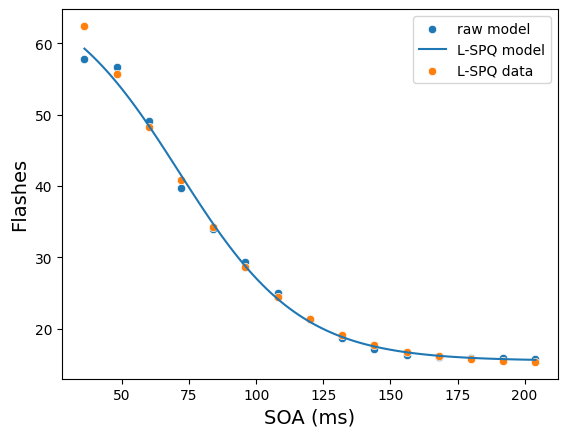

In [8]:
import matplotlib.pyplot as plt

sns.scatterplot(x=soas, y=fb_raw_model_data, label="raw model")
sns.lineplot(x=sig_soas, y=fb_model_data, label="L-SPQ model")
sns.scatterplot(
    data=dataset.query("Group == 'L-SPQ'"), y="Fit", x="Delay", label="L-SPQ data"
)
plt.ylabel("Flashes", size=14)
plt.xlabel("SOA (ms)", size=14)
plt.show()

In [11]:
from matplotlib.ticker import ScalarFormatter


def plot_res_per_soa(result_list, position=15):
    fig, axs = plt.subplots(3, 5, figsize=(16, 8), sharex=True, sharey=True, dpi=600)
    dashes_dict = {"auditory": "", "visual": "", "multi": (2, 2)}
    idx = -1
    for res in result_list:
        idx += 1
        row, col = idx // 5, idx % 5
        sub_plot = res.plot.linet(
            position=position,
            ax=axs[row, col],
            style="modes",
            dashes=dashes_dict,
            palette=["gray", "black", "gray"],
        )[0]
        sub_plot.get_legend().remove()
        sub_plot.set_title(
            "SOA " + str(int(res.run_parameters.auditory_soa)) + " ms",
            size=12,
            weight="bold",
        )
        sub_plot.set_ylabel("Neural activation", size=11, weight="bold")
        sub_plot.set_xlabel("Time (ms)", size=11, weight="bold")
        sub_plot.set_xlim(0, 60000)
        sub_plot.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
        new_labels = [label.get_text()[:-2] for label in sub_plot.get_xticklabels()]
        if new_labels:
            new_labels[1] = "0"
        sub_plot.set_xticklabels(new_labels)
    handles, legend_labels = sub_plot.get_legend_handles_labels()
    new_legend_labels = ["Auditory", "Visual", "Multisensory"]
    fig.suptitle(None)
    fig.legend(handles, new_legend_labels, loc="center right", borderaxespad=0.75)
    plt.subplots_adjust(right=0.90)
    plt.show()


def plot_res_per_soa_small(result_list, position=15):
    fig, axs = plt.subplots(1, 3, figsize=(14, 3), sharex=True, sharey=True, dpi=600)
    dashes_dict = {"auditory": "", "visual": "", "multi": (2, 2)}
    idx = -1
    for res in result_list[0::7]:
        idx += 1
        col = idx
        sub_plot = res.plot.linet(
            position=position,
            ax=axs[col],
            style="modes",
            dashes=dashes_dict,
        )[0]
        sub_plot.get_legend().remove()
        sub_plot.set_title(
            "SOA " + str(int(res.run_parameters.auditory_soa)) + " ms",
            size=12,
            weight="bold",
        )
        sub_plot.set_ylabel("Neural activation", size=11, weight="bold")
        sub_plot.set_xlabel("Time (ms)", size=11, weight="bold")
        sub_plot.set_xlim(0, 60000)
        sub_plot.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
        new_labels = [label.get_text()[:-2] for label in sub_plot.get_xticklabels()]
        if new_labels:
            new_labels[1] = "0"
        sub_plot.set_xticklabels(new_labels)
    handles, legend_labels = sub_plot.get_legend_handles_labels()
    new_legend_labels = ["Auditory", "Visual", "Multisensory"]
    fig.legend(handles, new_legend_labels, loc="center right", borderaxespad=0.2)
    fig.suptitle(None)
    # fig.savefig("drafts/FIG2.eps", bbox_inches="tight", format="eps")
    plt.subplots_adjust(wspace=0.1)
    plt.show()

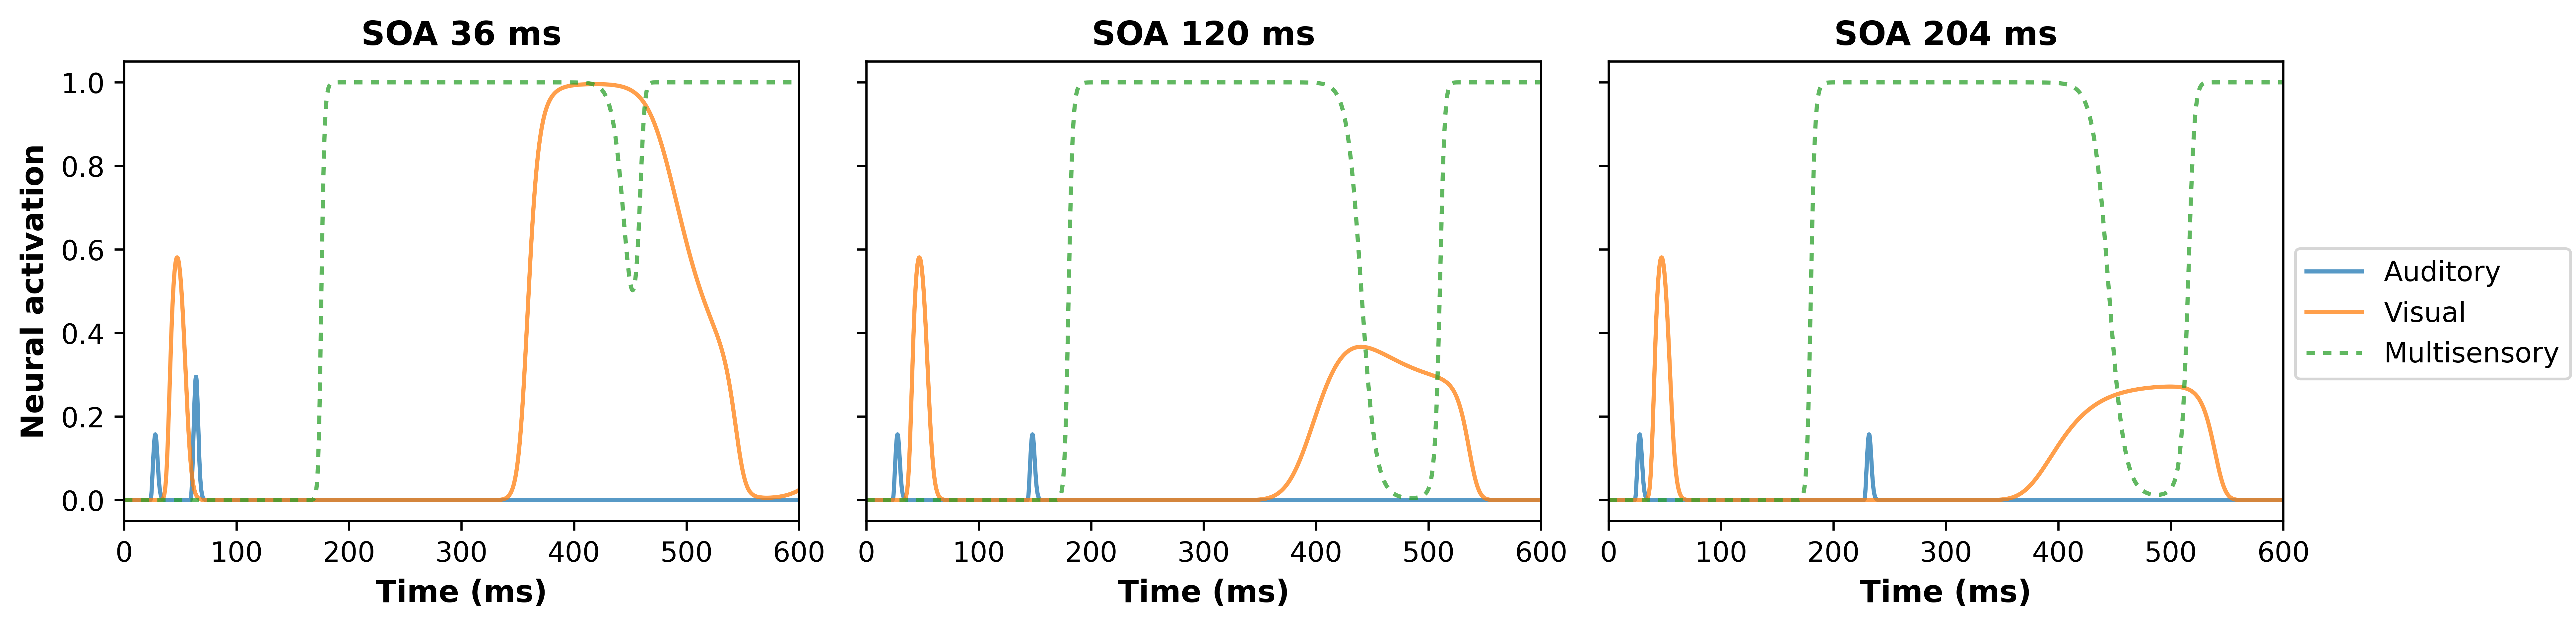

In [12]:
plot_res_per_soa_small(results)

In [42]:
df.query("positions==15")

,,modes,auditory,multi,visual
times,positions,positions_coordinates,,,
0,15,x0,1.266417e-16,1.266417e-16,1.266417e-16
1,15,x0,2.520169e-16,2.520169e-16,2.520169e-16
2,15,x0,3.761384e-16,3.761384e-16,3.761384e-16
3,15,x0,4.990187e-16,4.990187e-16,4.990187e-16
4,15,x0,6.206701e-16,6.206701e-16,6.206701e-16
...,...,...,...,...,...
59995,15,x0,8.495205e-11,1.000000e+00,2.368582e-02
59996,15,x0,8.495728e-11,1.000000e+00,2.370079e-02
59997,15,x0,8.496250e-11,1.000000e+00,2.371577e-02


In [54]:
df = results[-1].get_modes().query("positions==15")
norm_df = (df - df.min()) / (df.max() - df.min())
norm_df

,,modes,auditory,multi,visual
times,positions,positions_coordinates,,,
0,15,x0,0.000000e+00,0.000000e+00,0.000000e+00
1,15,x0,7.972903e-16,1.253752e-16,2.158264e-16
2,15,x0,1.586608e-15,2.494967e-16,4.294945e-16
3,15,x0,2.368032e-15,3.723770e-16,6.410260e-16
4,15,x0,3.141642e-15,4.940285e-16,8.504421e-16
...,...,...,...,...,...
59995,15,x0,9.827173e-14,1.000000e+00,3.473192e-10
59996,15,x0,9.827803e-14,1.000000e+00,3.463941e-10
59997,15,x0,9.828436e-14,1.000000e+00,3.454717e-10


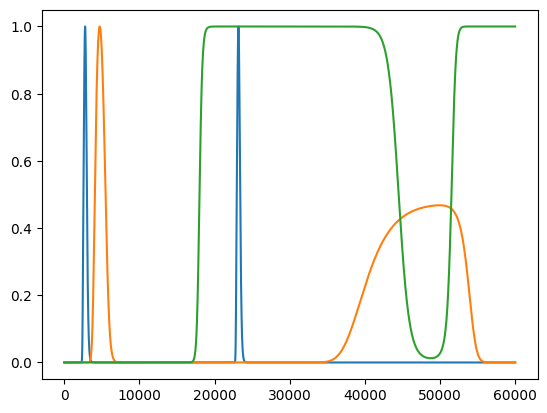

In [55]:
plt.plot(norm_df["auditory"].values)
plt.plot(norm_df["visual"].values)
plt.plot(norm_df["multi"].values)

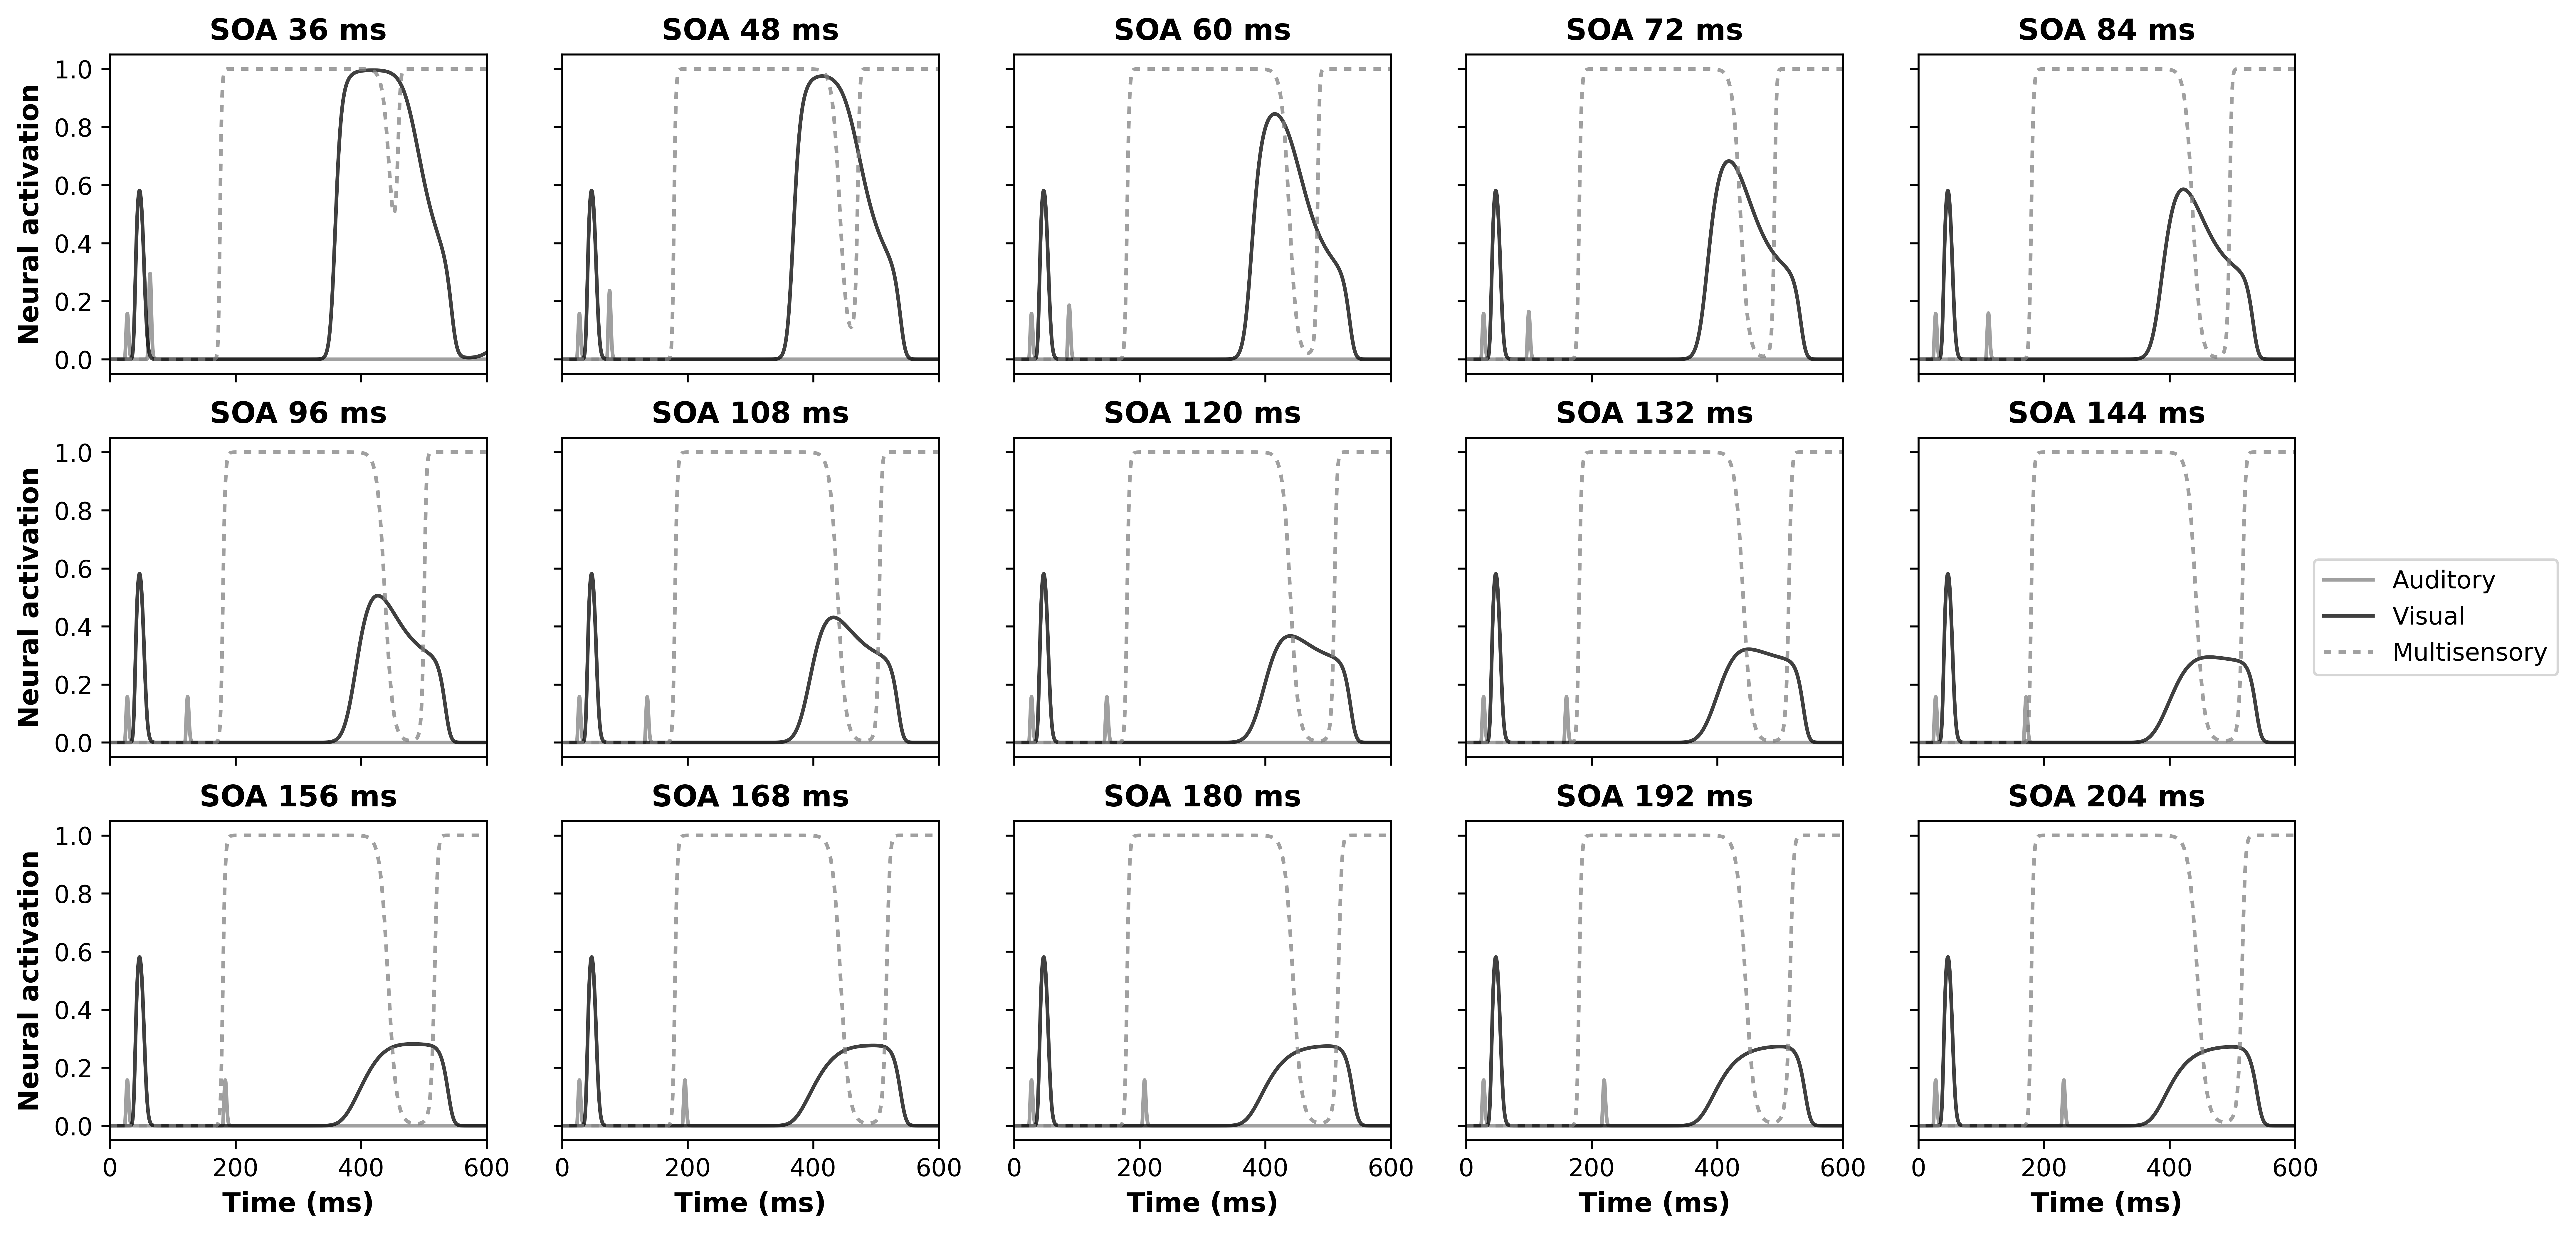

In [17]:
plot_res_per_soa(results)